In [108]:
import numpy as np
import matplotlib.pyplot as plt
import wf_psf as wf_psf

import matplotlib as mpl
from matplotlib.colors import ListedColormap

In [109]:
# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [2]:
# Paths

# SED folder path
SED_path = '../../../wf-psf/data/SEDs/save_SEDs/'

# Output saving path
#output_folder = '../output/'

# Reference dataset PATH
reference_data = '../../interp_SED_model/interp_SED_data/reference_dataset/'
ref_train = 'train_Euclid_res_2000_TrainStars_id_001.npy'
ref_test  = 'test_Euclid_res_id_001.npy'
selected_id_SED_path = 'selected_id_SED.npy'

In [3]:
# This list must be in order from bigger to smaller
n_star_list = [4]
n_test_stars = 1  # 20% of the max test stars
# Total stars
n_stars = n_star_list[0] + n_test_stars
# Max train stars
tot_train_stars = n_star_list[0]

# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
auto_init = False
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True

# Values for getting 3xEuclid_resolution PSFs outputs.
original_out_Q = output_Q
original_out_dim = output_dim
super_out_Q = 1
super_out_res = 64

# Desired WFE resolutions
WFE_resolutions = [256]

In [4]:
pupil_diameter_ =  WFE_resolutions[0]

zernikes_multires =  wf_psf.utils.zernike_generator(n_zernikes=max_order, wfe_dim=pupil_diameter_)

PSFtool = wf_psf.SimPSFToolkit(
        zernikes_multires, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
        output_Q=output_Q, output_dim=output_dim, pupil_diameter=pupil_diameter_, euclid_obsc=euclid_obsc,
        LP_filter_length=LP_filter_length)

PSFgen = wf_psf.GenPolyFieldPSF(PSFtool, d_max=d_max,
        grid_points=grid_points, max_order=max_order,
        x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
        lim_max_wfe_rms=max_wfe_rms, auto_init=auto_init, verbose=verbose)

In [5]:
# Load reference dataset
selected_id_SED = np.load(reference_data+'selected_id_SED.npy', allow_pickle=True)
train_dataset_ref = np.load(reference_data+ref_train, allow_pickle=True)[()]
test_dataset_ref = np.load(reference_data+ref_test, allow_pickle=True)[()]

# Load the SEDs
stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)

# Load all the stars positions and assign SEDs
pos_np = np.vstack((train_dataset_ref['positions'],test_dataset_ref['positions']))
SED_list = []
for it in range(n_stars):
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[selected_id_SED[it],:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)

# Load and assign the C_poly matrix
C_poly = train_dataset_ref['C_poly']
PSFgen.set_C_poly(C_poly)


## Generate a PSF in $\times 1$ and $\times 3$ resolution

In [6]:
star_id = 0

psf_lres, _zernike, _ = PSFgen.get_poly_PSF(xv_flat=pos_np[star_id, 0],
                                                           yv_flat=pos_np[star_id, 1],
                                                           SED=SED_list[star_id])
PSFgen.sim_psf_toolkit.output_Q = super_out_Q
PSFgen.sim_psf_toolkit.output_dim = super_out_res
psf_hres, _, _ = PSFgen.get_poly_PSF(xv_flat=pos_np[star_id, 0],
                                                        yv_flat=pos_np[star_id, 1],
                                                        SED=SED_list[star_id])
# Put back original parameters
PSFgen.sim_psf_toolkit.output_Q = original_out_Q
PSFgen.sim_psf_toolkit.output_dim = original_out_dim



## Add defocus to the WFE

In [7]:
def get_poly_psf_defocused(PSFgen, xv_flat, yv_flat, SED):
    # Calculate the specific field's zernike coeffs
    zernikes = PSFgen.calc_zernike(xv_flat, yv_flat)
    # Add defocus
    zernikes[3] += 2
    # Set the Z coefficients to the PSF toolkit generator
    PSFgen.sim_psf_toolkit.set_z_coeffs(zernikes)
    poly_psf = PSFgen.sim_psf_toolkit.generate_poly_PSF(SED, n_bins=PSFgen.n_bins)
    opd = PSFgen.sim_psf_toolkit.opd

    return poly_psf, zernikes, opd

In [26]:
defocus = 0.15

zernikes = PSFgen.calc_zernike(pos_np[star_id, 0], pos_np[star_id, 1])
# Add defocus
zernikes[3] += defocus
# Set the Z coefficients to the PSF toolkit generator
PSFgen.sim_psf_toolkit.set_z_coeffs(zernikes)
# Get the PSF and the WFE
defocus_psf_lres = PSFgen.sim_psf_toolkit.generate_poly_PSF(SED_list[star_id], n_bins=PSFgen.n_bins)
defocus_opd = PSFgen.sim_psf_toolkit.opd

# Get PSF at higher resolution
PSFgen.sim_psf_toolkit.output_Q = super_out_Q
PSFgen.sim_psf_toolkit.output_dim = super_out_res
defocus_psf_hres = PSFgen.sim_psf_toolkit.generate_poly_PSF(SED_list[star_id], n_bins=PSFgen.n_bins)
# Put back original parameters
PSFgen.sim_psf_toolkit.output_Q = original_out_Q
PSFgen.sim_psf_toolkit.output_dim = original_out_dim


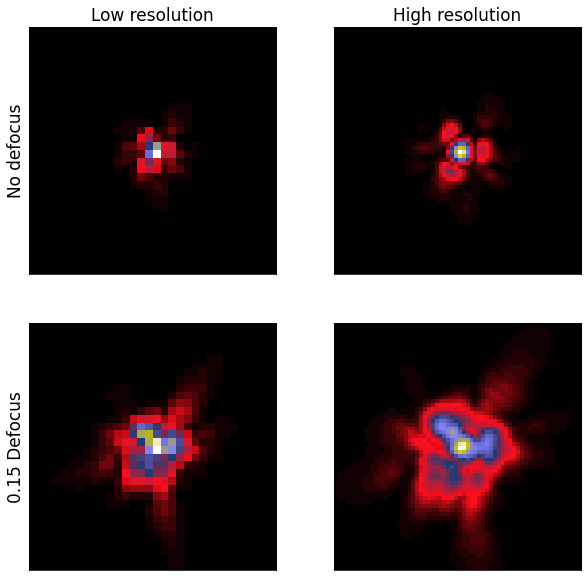

In [27]:
text_size = 17

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  
})

fig, ax = plt.subplots(2,2, figsize=(10,10))

im = ax[0][0].imshow(psf_lres, cmap='gist_stern')
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
ax[0][0].set_ylabel('No defocus', fontsize=text_size)
ax[0][0].set_title('Low resolution', fontsize=text_size)

im = ax[0][1].imshow(psf_hres, cmap='gist_stern')
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])
ax[0][1].set_title('High resolution', fontsize=text_size)

im = ax[1][0].imshow(defocus_psf_lres, cmap='gist_stern')
ax[1][0].set_xticks([])
ax[1][0].set_yticks([])
ax[1][0].set_ylabel('{} Defocus'.format(defocus), fontsize=text_size)

im = ax[1][1].imshow(defocus_psf_hres, cmap='gist_stern')
ax[1][1].set_xticks([])
ax[1][1].set_yticks([])

plt.show()

## Generate a bunch of PSFs with different defocus levels

In [99]:

defocus_max = 0.2
defocus_step = 0.02

defocus_values = np.linspace(-defocus_max, defocus_max, num=11)

star_defocus_PSF_lres_list = []
star_defocus_PSF_hres_list = []
star_defocus_OPD_list = []

for star_id in range(n_stars):
    defocus_PSF_lres_list = []
    defocus_PSF_hres_list = []
    defocus_OPD_list = []

    for defocus in defocus_values:
        zernikes = PSFgen.calc_zernike(pos_np[star_id, 0], pos_np[star_id, 1])
        # Add defocus
        zernikes[3] += defocus
        # Set the Z coefficients to the PSF toolkit generator
        PSFgen.sim_psf_toolkit.set_z_coeffs(zernikes)
        # Get the PSF and the WFE
        defocus_psf_lres_ = PSFgen.sim_psf_toolkit.generate_poly_PSF(SED_list[star_id], n_bins=PSFgen.n_bins)
        defocus_opd_ = PSFgen.sim_psf_toolkit.opd

        # Get PSF at higher resolution
        PSFgen.sim_psf_toolkit.output_Q = super_out_Q
        PSFgen.sim_psf_toolkit.output_dim = super_out_res
        defocus_psf_hres_ = PSFgen.sim_psf_toolkit.generate_poly_PSF(SED_list[star_id], n_bins=PSFgen.n_bins)
        # Put back original parameters
        PSFgen.sim_psf_toolkit.output_Q = original_out_Q
        PSFgen.sim_psf_toolkit.output_dim = original_out_dim

        defocus_PSF_lres_list.append(defocus_psf_lres_)
        defocus_PSF_hres_list.append(defocus_psf_hres_)
        defocus_OPD_list.append(defocus_opd_)

    star_defocus_PSF_lres_list.append(defocus_PSF_lres_list)
    star_defocus_PSF_hres_list.append(defocus_PSF_hres_list)
    star_defocus_OPD_list.append(defocus_OPD_list)

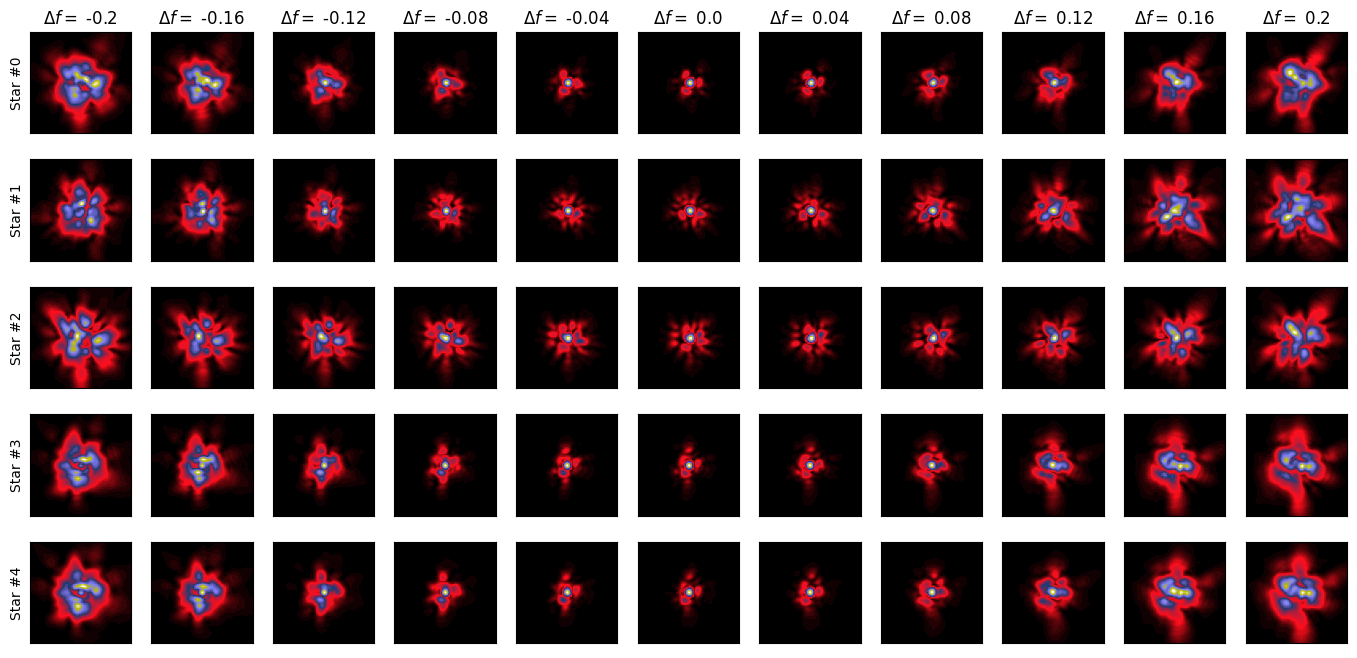

In [106]:
fig, ax = plt.subplots(n_stars,len(defocus_values), figsize=(17,8))

for star_id, defocus_PSF_list in enumerate(star_defocus_PSF_hres_list):
    for i,psf_ in enumerate(defocus_PSF_list):
        ax[star_id][i].imshow(psf_, cmap='gist_stern')
        ax[star_id][i].set_xticks([])
        ax[star_id][i].set_yticks([])
        if star_id == 0:
            ax[star_id][i].set_title('$\Delta f=$ {}'.format(np.round(defocus_values[i],2)))
        if i == 0:
            ax[star_id][i].set_ylabel('Star #{}'.format(star_id))

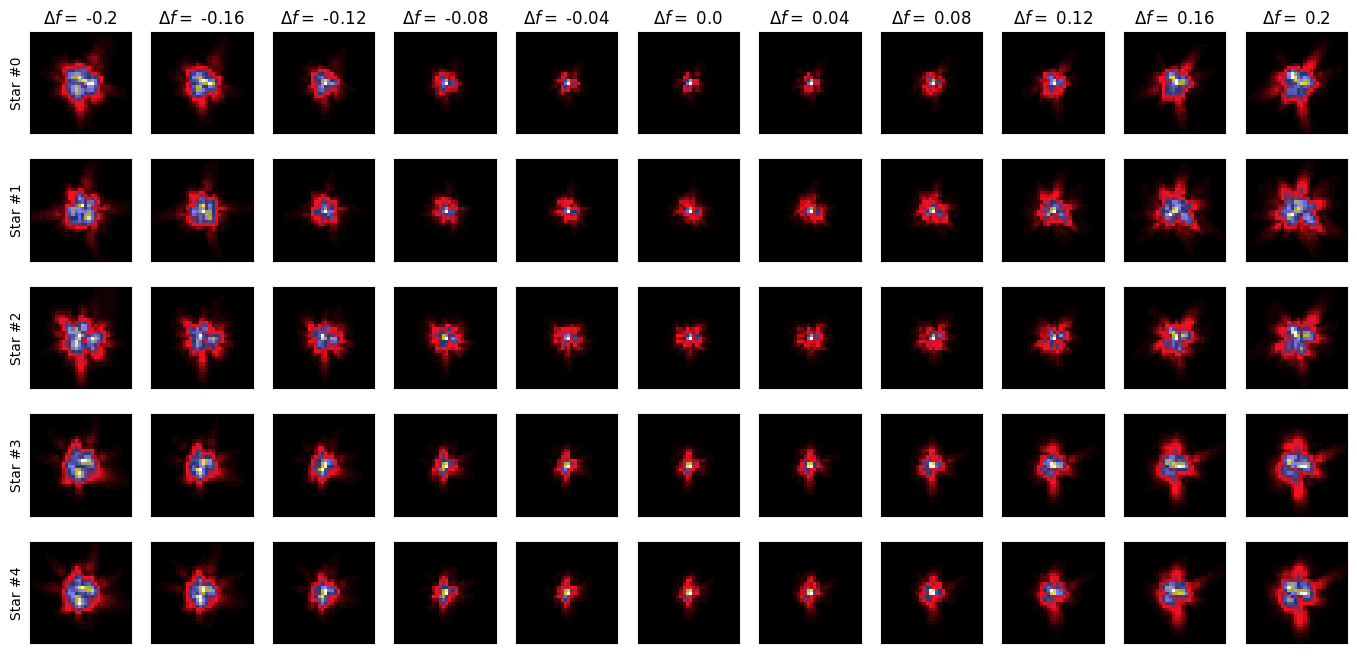

In [124]:
fig, ax = plt.subplots(n_stars,len(defocus_values), figsize=(17,8))

for star_id, defocus_PSF_list in enumerate(star_defocus_PSF_lres_list):
    for i,psf_ in enumerate(defocus_PSF_list):
        ax[star_id][i].imshow(psf_, cmap='gist_stern')
        ax[star_id][i].set_xticks([])
        ax[star_id][i].set_yticks([])
        if star_id == 0:
            ax[star_id][i].set_title('$\Delta f=$ {}'.format(np.round(defocus_values[i],2)))
        if i == 0:
            ax[star_id][i].set_ylabel('Star #{}'.format(star_id))

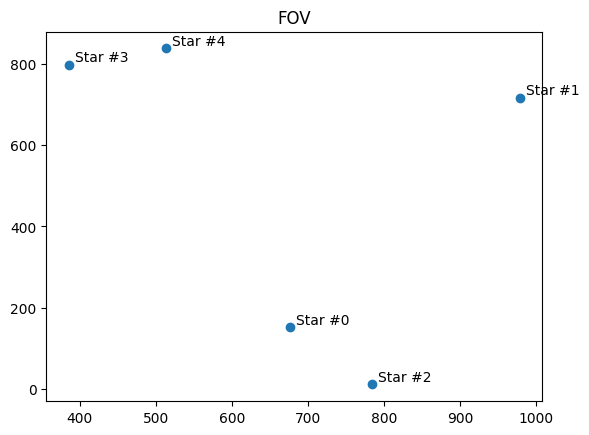

In [123]:
plt.scatter(pos_np[0:5][:,0], pos_np[0:5][:,1])
plt.title('FOV')
offset = 8
for i in range(n_stars):
    plt.annotate('Star #{}'.format(i), (pos_np[0:5][i,0] + offset, pos_np[0:5][i,1] + offset))

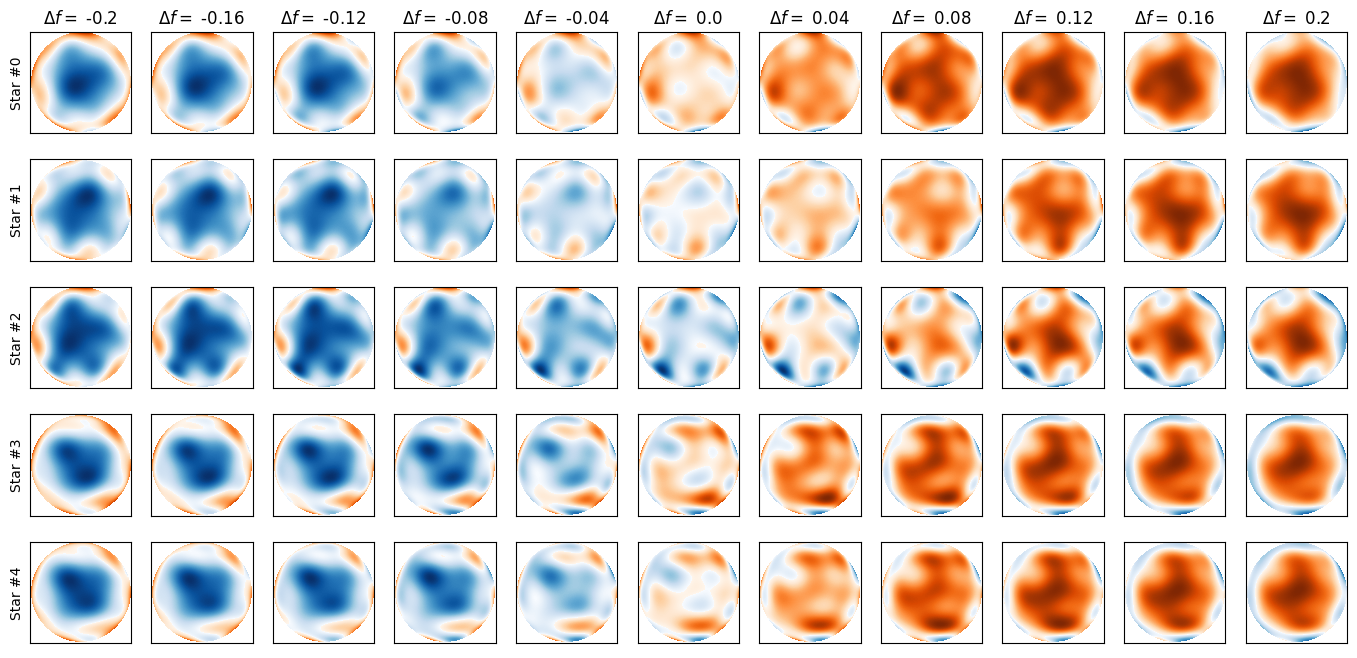

In [110]:
fig, ax = plt.subplots(n_stars,len(defocus_values), figsize=(17,8))

for star_id, defocus_OPD_list in enumerate(star_defocus_OPD_list):
    for i,opd_ in enumerate(defocus_OPD_list):
        ax[star_id][i].imshow(opd_, cmap=newcmp)
        ax[star_id][i].set_xticks([])
        ax[star_id][i].set_yticks([])
        if star_id == 0:
            ax[star_id][i].set_title('$\Delta f=$ {}'.format(np.round(defocus_values[i],2)))
        if i == 0:
            ax[star_id][i].set_ylabel('Star #{}'.format(star_id))